In [3]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix
from sklearn.datasets import make_sparse_spd_matrix
plt.rcParams["axes.grid"] = False
import matplotlib.image as mpimg
from scipy.spatial import distance
import os
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage

### Set up location and scale for the random gaussian data

In [4]:
c_2D =6
dots_2D = 50
sprad_2D = 25
eps = 1e-8

In [5]:
labels_2D = np.array(range(0,c_2D))
labels_2D = np.repeat(labels_2D, dots_2D)
mu_x_2D = np.random.random_integers(0,sprad_2D+1,c_2D)
mu_y_2D = np.random.random_integers(0,sprad_2D+1,c_2D)

C:\Users\dorli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 26 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dorli\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 26 + 1) instead
  after removing the cwd from sys.path.


# Create the data from Normal distributions

In [6]:
mean_2D = np.zeros((c_2D,2))
cov_2D = np.zeros((c_2D,2,2))
for i in range(0,c_2D):
    mean_2D[i,0] = mu_x_2D[i]
    mean_2D[i,1] = mu_y_2D[i]
    cov_2D[i,:,:] = make_spd_matrix(2) #+ np.identity(2) * np.random.random_sample()

In [7]:
X_data_2D = np.zeros((c_2D*dots_2D,2))
for i in range(0,c_2D):
    X_data_2D[i*dots_2D:(i+1)*dots_2D,:] = np.random.multivariate_normal(mean_2D[i], cov_2D[i], dots_2D)
original_data = X_data_2D.copy()

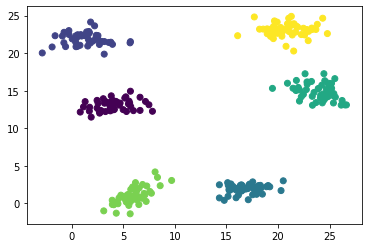

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_data_2D[:,0], X_data_2D[:,1], c = labels_2D)

In [9]:
np.random.shuffle(X_data_2D)

# Agglomerative Hierarchical Clustering

### Set up global parameters 

In [13]:
def compute_dist_matrix(X_data_2D, clusters, method):
    unique_c = np.unique(clusters).shape[0]
    D = np.zeros((unique_c,unique_c))
    for i in np.unique(clusters):
        for j in np.unique(clusters):
            if i != j:
                D_i = X_data_2D[clusters == i]
                D_j = X_data_2D[clusters == j]
                if method == 'min':
                    dist_i_j = dist_min(X_data_2D, D_i, D_j)
                elif method == 'max':
                    dist_i_j = dist_max(X_data_2D, D_i, D_j)
                elif method == 'avg':
                    dist_i_j = dist_avg(X_data_2D, D_i, D_j)
                elif method == 'mean':
                    dist_i_j = dist_mean(X_data_2D, D_i, D_j)
                else: 
                    dist_i_j = 0
                    print("ERROR: wrong mathod typed, please type one of the options: 'min', 'max', 'avg', 'mean'")
                D[int(i),int(j)] = dist_i_j
    return D

In [14]:
def dist_min(X_data_2D, D_i, D_j):
    minimum = np.maximum(np.max(D_i), np.max(D_j))
    for d_i in D_i:
        for d_j in D_j:
            dist = distance.euclidean(d_i, d_j)
            if dist < minimum:
                minimum = dist
            if dist < 0:
                print(minimum)
    return minimum

In [15]:
def dist_max(X_data_2D, D_i, D_j):
    maximum = 0
    for d_i in D_i:
        for d_j in D_j:
            dist = abs(distance.euclidean(d_i, d_j))
            if dist > maximum:
                maximum = dist
    return maximum

In [16]:
def dist_avg(X_data_2D, D_i, D_j):
    ni = D_i.shape[0]
    nj = D_j.shape[0]
    sum_all = 0
    for d_i in D_i:
        for d_j in D_j:
            sum_all = sum_all + abs(distance.euclidean(d_i, d_j))
    return sum_all / (ni*nj)

In [17]:
def dist_mean(X_data_2D, D_i, D_j):
    mean_i = np.mean(D_i, axis=0)
    mean_j = np.mean(D_j, axis=0)
    return abs(distance.euclidean(mean_i, mean_j))

In [18]:
def find_clusters_to_merge(D):
    return np.where(D==np.min(D[np.nonzero(D)]))[0][0], np.where(D==np.min(D[np.nonzero(D)]))[1][0]

In [19]:
def merge_D_i_D_j(new_idx, replace, clusters):
    new_idx_mat = np.zeros(clusters.shape)
    new_idx_mat.fill(new_idx)
    new_clusters = np.where(clusters == replace, new_idx_mat, clusters)
    
    unique = np.unique(new_clusters).shape[0]
    list_idx = [i for i in range(0,unique)]
    for i in list_idx:
        if i not in new_clusters:
            max_idx = np.max(clusters)
            new_idx_mat.fill(i)
            new_clusters = np.where(clusters == max_idx, new_idx_mat, new_clusters)
    return new_clusters


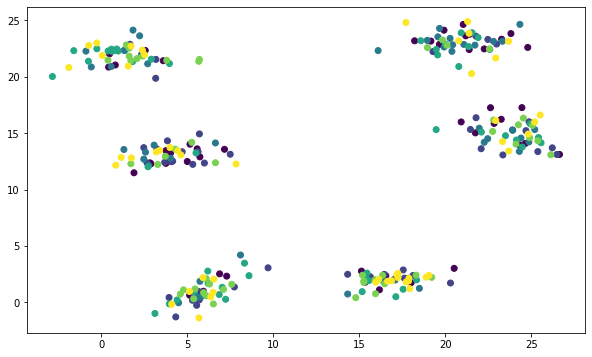

In [20]:
f, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(X_data_2D[:,0], X_data_2D[:,1], c = labels_2D)
plt.show()

# The algorithm

In [60]:
def AHC(C_min, C_max, method, X_data_2D):
    plot_clusters = []
    #Initialize to each data point a label 
    clusters = np.array(range(0,X_data_2D.shape[0]))
    #compute first data matrix: 
    D = compute_dist_matrix(X_data_2D, clusters, method)

    while np.unique(clusters).shape[0] >= C_min and np.unique(clusters).shape[0] > 1:
        idx_i, idx_j = find_clusters_to_merge(D)
        clusters = merge_D_i_D_j(min(idx_i, idx_j), max(idx_i, idx_j), clusters)
        D = compute_dist_matrix(X_data_2D, clusters, method)
        
        if C_min <= np.unique(clusters).shape[0] <= C_max:
            plot_clusters.append(clusters)
            f, ax = plt.subplots(1,1, figsize=(7,7))
            ax.scatter(X_data_2D[:,0], X_data_2D[:,1], c = clusters)
            #plt.savefig('./'+ method + '_results/' + "clusters_{0:02d}".format(np.unique(clusters).shape[0]))
            plt.show()

    return plot_clusters

In [62]:
C_max = 10
C_min = 3

#choose a method to run 
method = 'min' # 'min', 'max', 'avg', 'mean'

X_data_2D = iris_3


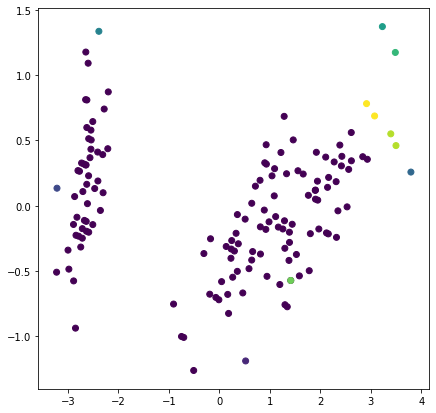

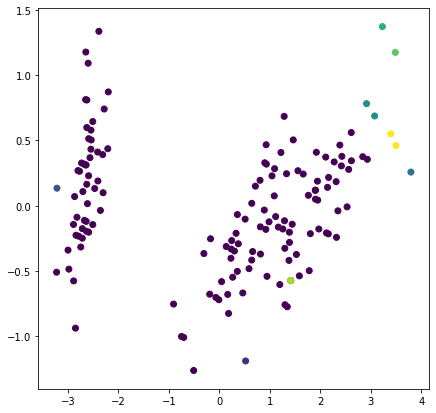

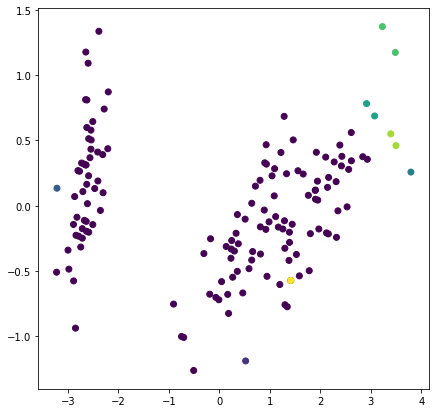

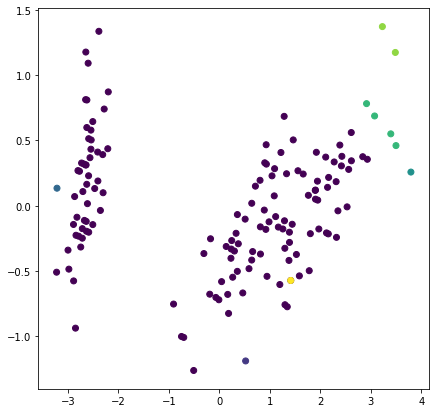

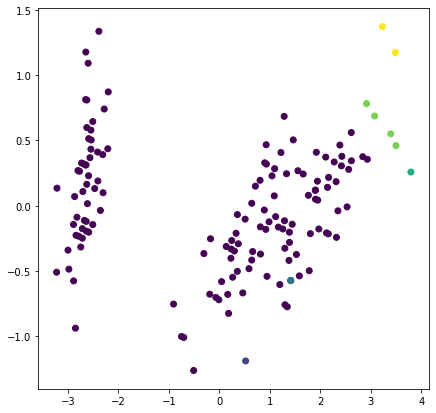

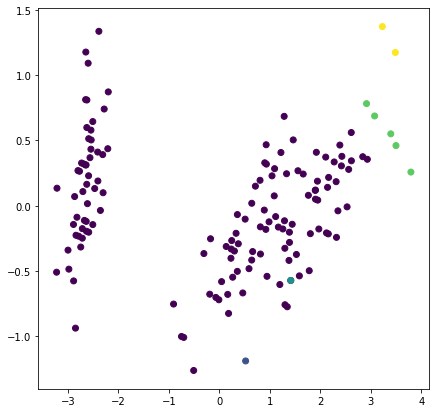

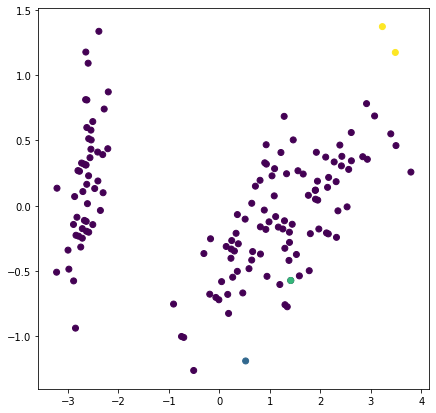

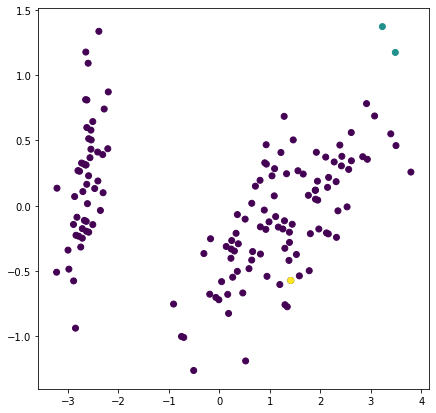

In [63]:
clusters_min = AHC(C_min, C_max, 'min', X_data_2D)

In [64]:
clusters_min[0].shape

(150,)

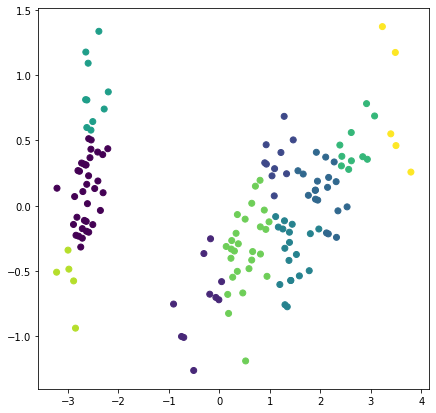

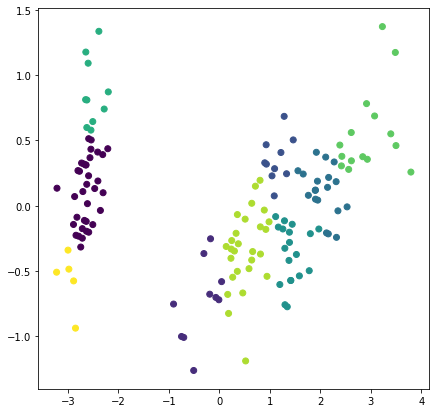

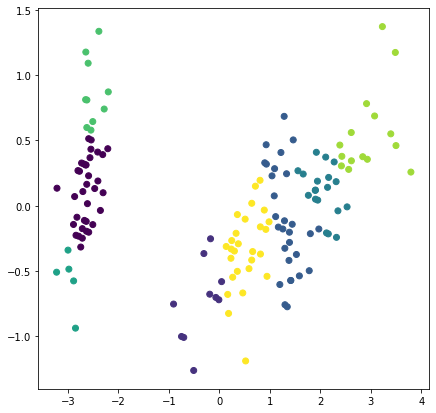

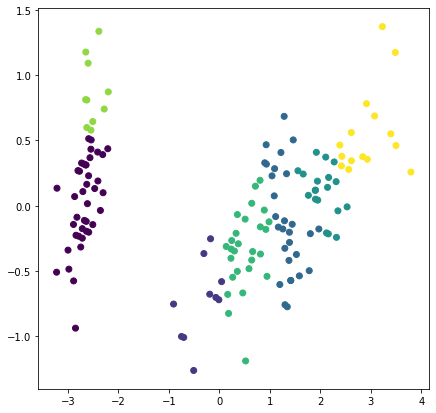

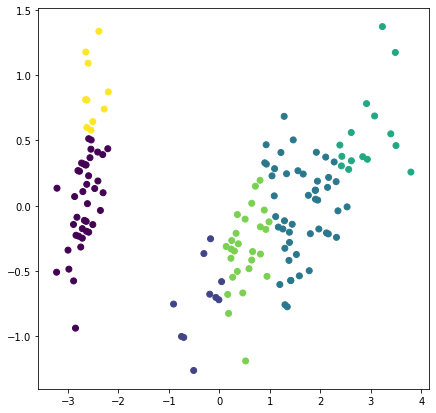

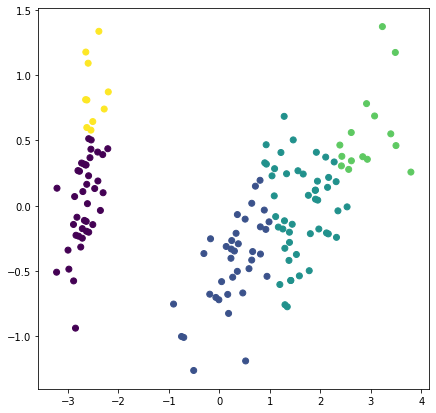

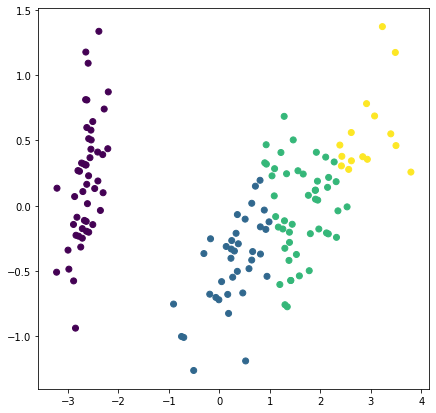

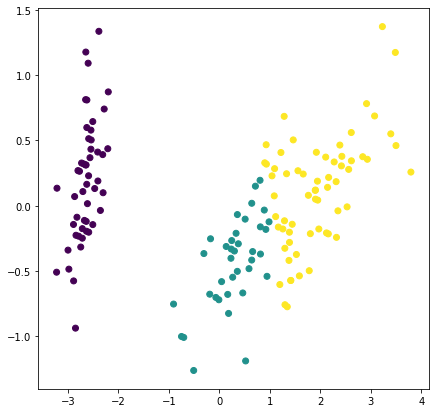

In [65]:
clusters_max = AHC(C_min, C_max, 'max', X_data_2D)

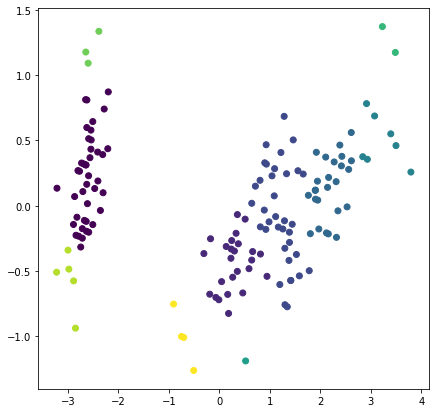

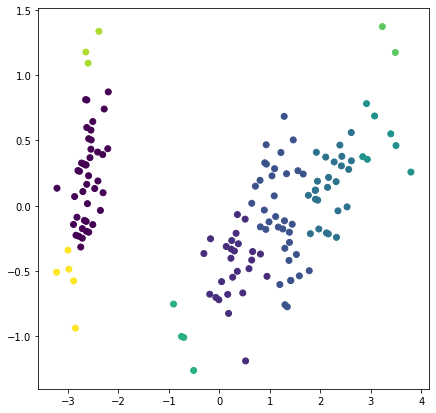

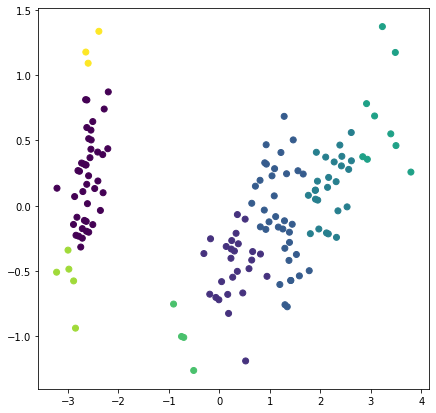

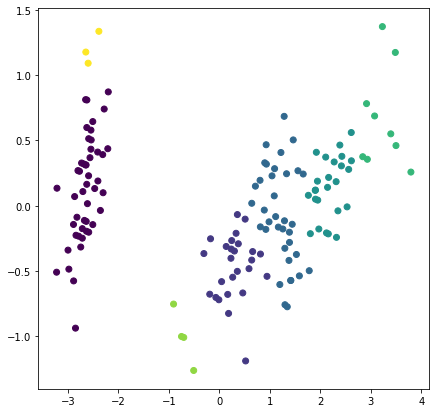

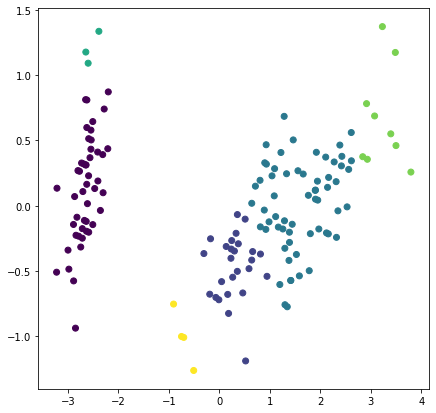

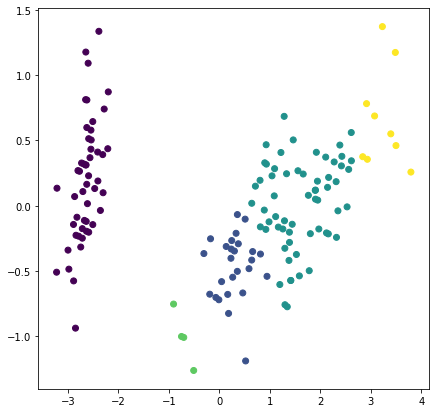

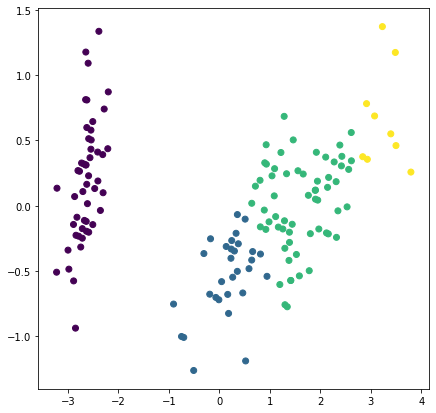

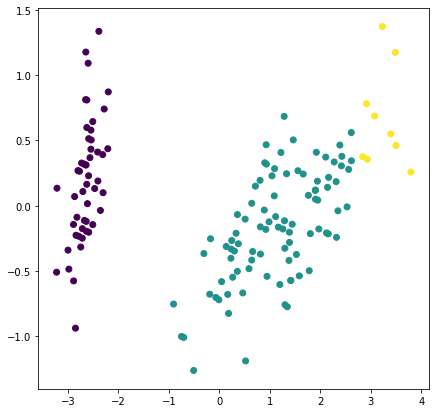

In [66]:
clusters_avg = AHC(C_min, C_max, 'avg', X_data_2D)

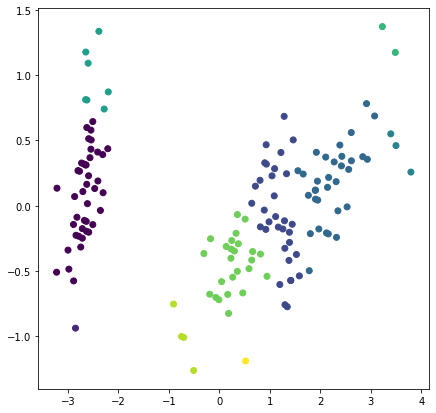

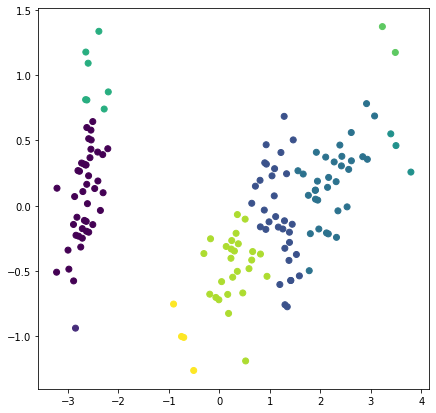

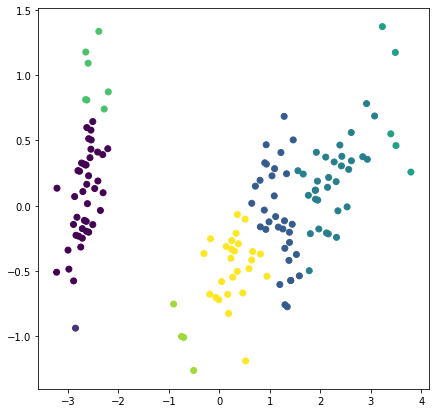

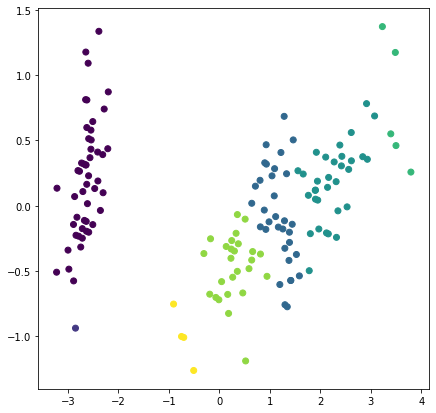

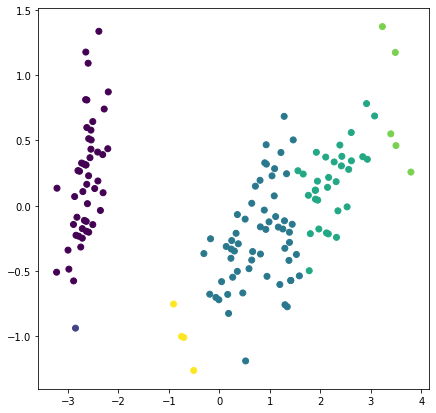

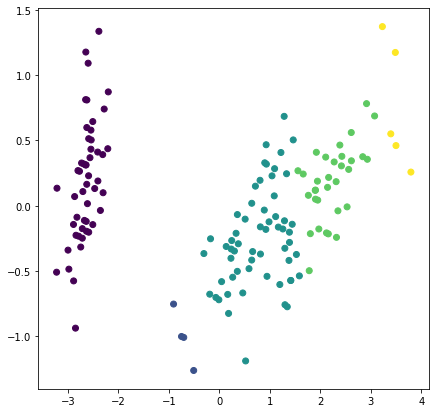

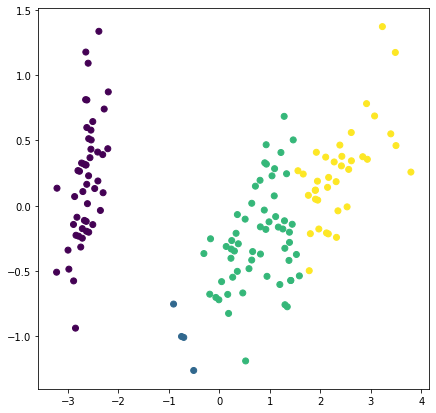

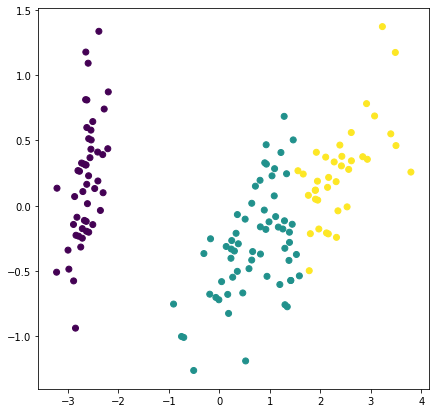

In [67]:
clusters_mean =AHC(C_min, C_max, 'mean', X_data_2D)

# Results Plotting

In [68]:
def plot_4_type_with_k_clusters(clusters_min, clusters_max, clusters_avg, clusters_mean, k):

    f, ax = plt.subplots(1, 4, figsize=(20,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.00001, hspace=0.000000001)
    ax[0].scatter(X_data_2D[:,0], X_data_2D[:,1], c = clusters_min[k])
    ax[1].scatter(X_data_2D[:,0], X_data_2D[:,1], c = clusters_max[k])
    ax[2].scatter(X_data_2D[:,0], X_data_2D[:,1], c = clusters_avg[k])
    ax[3].scatter(X_data_2D[:,0], X_data_2D[:,1], c = clusters_mean[k])

    ax[0].set_title("min results")
    ax[1].set_title("max results")
    ax[2].set_title("avg results")
    ax[3].set_title("mean results")
    plt.show()
    
    '''
    im_avg = mpimg.imread("./avg_results/" + f_avg[i])
    im_mean = mpimg.imread("./mean_results/" + f_mean[i])
    im_min = mpimg.imread("./min_results/" + f_min[i])
    im_max = mpimg.imread("./max_results/" + f_max[i])

    fig, ax = plt.subplots(1, 4, figsize=(20, 20))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.00001, hspace=0.0000000000001)
    ax[0].imshow(im_avg)
    ax[1].imshow(im_mean)
    ax[2].imshow(im_min)
    ax[3].imshow(im_max)
    ax[0].set_title("avg results")
    ax[1].set_title("mean results")
    ax[2].set_title("min results")
    ax[3].set_title("max results")
    plt.show()
    '''

In [69]:
f_avg = os.listdir("./avg_results")
f_mean = os.listdir("./mean_results")
f_min = os.listdir("./min_results")
f_max = os.listdir("./max_results")

## Results of 4 methods with k clusters

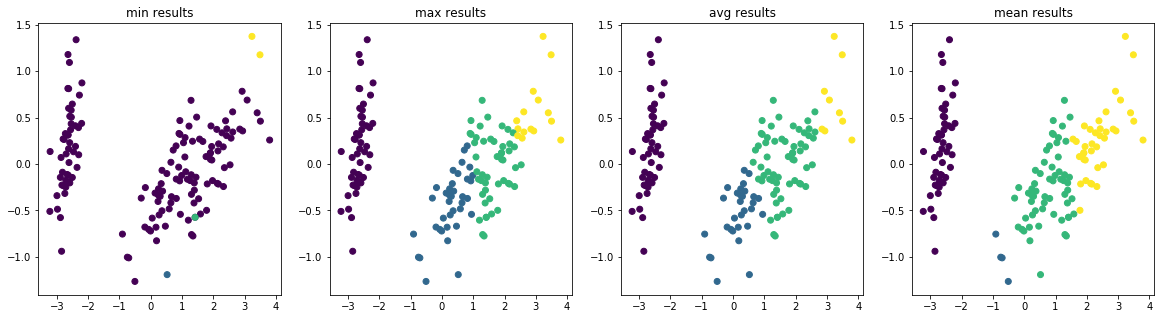

In [70]:
k = 6
plot_4_type_with_k_clusters(clusters_min, clusters_max, clusters_avg, clusters_mean, k)

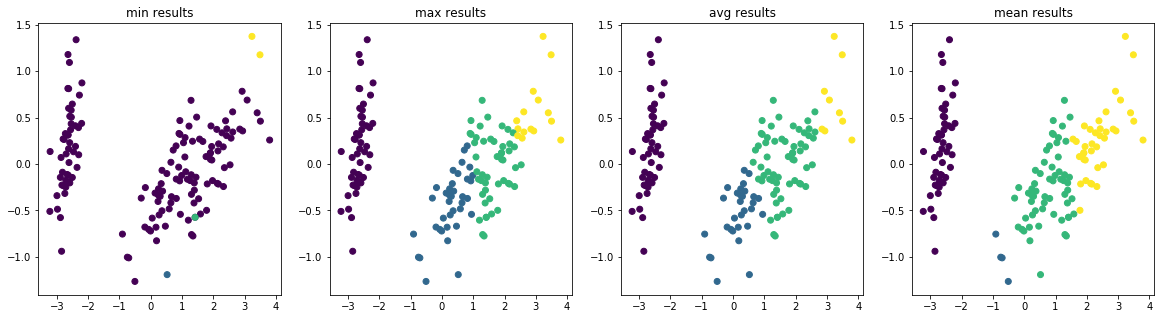

In [72]:
k = 6
plot_4_type_with_k_clusters(clusters_min, clusters_max, clusters_avg, clusters_mean, k)

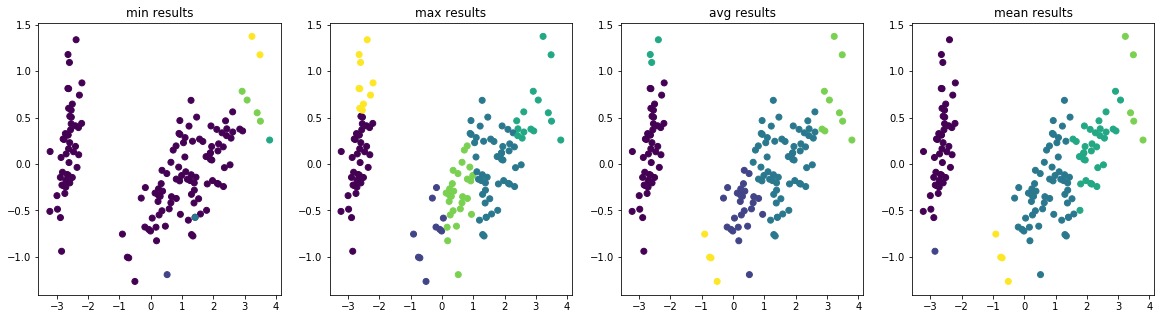

In [75]:
k = 4
plot_4_type_with_k_clusters(clusters_min, clusters_max, clusters_avg, clusters_mean, k)

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

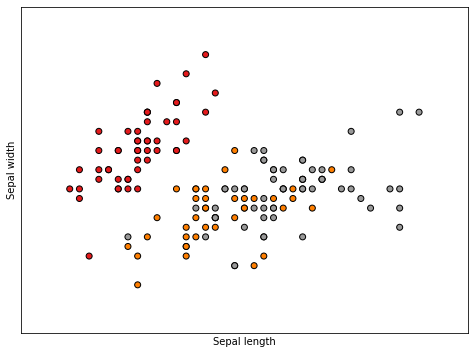

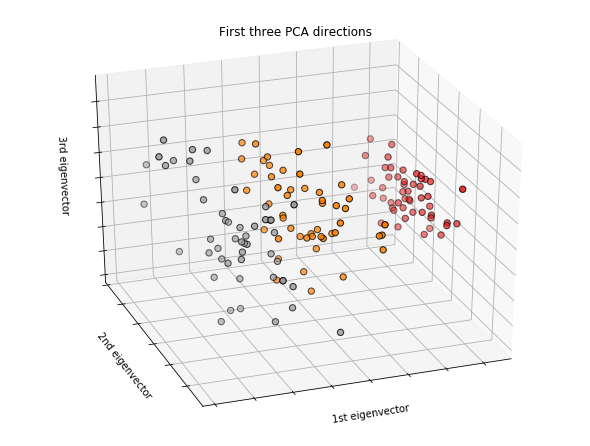

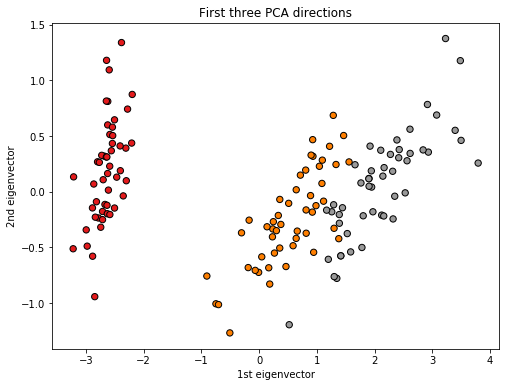

(150, 2)

In [48]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()


# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
X_reduced = PCA(n_components=2).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
plt.show()

iris_3 = np.array([X_reduced[:, 0], X_reduced[:, 1]]).T
X_reduced.shape

C:\Users\dorli\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


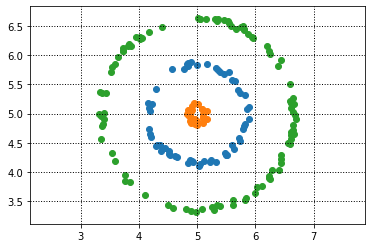

In [12]:
import matplotlib.pyplot as plt
from math import pi, cos, sin
import random

def point(h, k, r_start, r_stop):
    r = random.uniform(r_start, r_stop)
    theta = random.random() * 2 * pi
    return h + cos(theta) * r, k + sin(theta) * r
center_x = 5
center_y = 5
xy = [point(center_x,center_y,0.8,0.9) for _ in range(60)]
another_circle = [point(center_x,center_y,0.1,0.2) for _ in range(30)]
another_circle2 = [point(center_x,center_y,1.6,1.7) for _ in range(100)]

plt.scatter(*zip(*xy))
plt.scatter(*zip(*another_circle))
plt.scatter(*zip(*another_circle2))
plt.grid(color='k', linestyle=':', linewidth=1)
plt.axes().set_aspect('equal', 'datalim')
plt.show()

cir = np.array(xy)
cir1 = np.array(another_circle)
cir2 = np.array(another_circle2)
circles = np.concatenate((cir1, cir), axis=0)
circles = np.concatenate((circles, cir2), axis=0)